# Creating numerical representations for each of the products with Word2Vec

In this (rather short) notebook, I will demonstrate how simple it is to learn representations for each product in the shopping baskets with Word2Vec.

In [ ]:
!pip install adjustText

In [ ]:
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from adjustText import adjust_text

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

# Load our data (shopping baskets)

In [ ]:
data = pd.read_csv('../input/groceries/groceries - groceries.csv', header=0)
data.head(5)

# Create "sentences"

Word2Vec expects sentences as its input. For this dataset, each of the shopping baskets can be seen as a sentence and each of the products in the basket can be seen as a word. Word2Vec will then learn representations for each of these products by trying to either predict the other products in the basket based on 1 product (Skip-Gram) or a product based on the other products in the basket (Continuous Bag of Words)

In [ ]:
sentences = []
for i, row in data.iterrows():
    vals = row.values[1:].astype(str)
    
    # Remove the nans
    vals = vals[vals != 'nan']
    
    # Order does not really matter in shopping baskets (unlike English sentences)
    # so this is a form of augmentation
    for _ in range(min(3, len(vals))):
        np.random.shuffle(vals)
        sentences.append(list(vals))
        
print('\n'.join([', '.join(x) for x in sentences[:10]]))

# We now feed these sentences to Word2Vec

Feel free to play around with these hyper-parameters and see the impact on the embeddings!

In [ ]:
print('Embedding {} sentences...'.format(len(sentences)))
    
model = Word2Vec(
    sentences,
    size=10,
    window=3,
    workers=1,
    sg=0,
    iter=25,
    negative=25,
    min_count=1,
    seed=42,
    compute_loss=True
)

print(model.get_latest_training_loss())

# Create 2D t-SNE representation of embeddings

Let's take a look at our embeddings in a 2D scatter plot! We will use `adjustText` to not clutter the plot with our labels.

In [ ]:
products = list(model.wv.vocab.keys())
embeddings = []
for product in products:
    embeddings.append(model.wv[product])
embeddings = np.array(embeddings)
print(len(products), embeddings.shape)

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

texts = []
for x, y, lab in zip(X_tsne[:, 0], X_tsne[:, 1], products):
    text = plt.text(x, y, lab)
    texts.append(text)
    
adjust_text(texts, lim=5, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()

This is only a simple proof-of-concept with a rather small dataset. Nevertheless, we can see that the Word2Vec already learned some cool things! Due to stochastic elements in Word2Vec, the embeddings can look different each time. On the command-line, you can prevent this by adding `PYTHONHASHSEED=42` as a prefix.

In the image below, we can cleary identify a cluster of alcohol, we can see how mustard and frankfurter have been placed together, and so on... Cool beans!

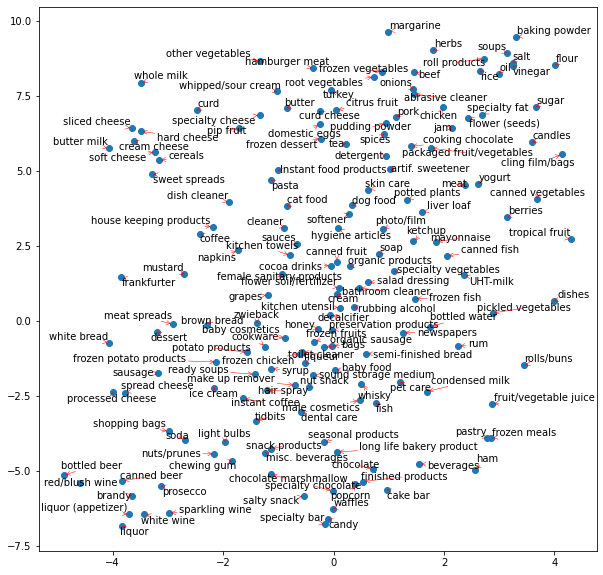